# Project 1: Classification Analysis on Textual Data

*Lumi Huang, Christian Warloe, Ke Zhao, Landi Luo*

## Introduction

---


Classification is a data mining technique that groups data into categories to aid in more accurate prediction and analysis. Classification refers to the problem of identifying which category a new observation belongs to, given a training set of data containing observations with known category membership. This project focuses on different methods for classifying textual data, including constructing a tf-idf matrix representation, dimensionality reduction techniques, and various classifiers such as linear SVMs and naive Bayes classifiers. 


## Getting familiar with the dataset

---



The dataset used for this project is the "20 Newsgroups" dataset, which consists of a collection of approximately 20,000 newsgroup documents partitioned (nearly) evenly across 20 topics. The dataset is split into two subsets: one for training (or development) and the other for testing (or for performance evaluation). 

<b><center> Dataset Characteristics </center></b> 

| Classes        | 20    |
|---|---|
| Samples Total  | 18846 |
| Dimensionality | 1     |
| Features       | text  |

We used the built-in dataset loader `fetch_20newsgroups` from `scikit-learn` to load the dataset. The [`sklearn.datasets.fetch_20newsgroups`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups) function is a data fetching / caching function that downloads the data archive from the original [20 newsgroups website](http://qwone.com/~jason/20Newsgroups/), extracts the archive contents in the `~/scikit_learn_data/20news_home` folder and calls the `sklearn.datasets.load_files` on either the training or testing set folder, or both of them. 

In [1]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
print(newsgroups_train.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


### Question 1: Histogram of the Data

We first plotted a histogram of the data to check for imbalances in the number of documents for each of the 20 newsgroup categories in the training dataset. If the data show an imbalance, we would need to properly account for that using methods like modifying the penalty function (assigning more weight to errors from smaller category sizes), or down-sampling the larger sized classes.  
As seen in the histogram below, the data appear to be approximately balanced; although we can see that categories like `talk.religion.misc`, `talk.politics.misc`, and `alt.atheism` have relatively smaller sizes compared to the rest, we will not be working with these categories in our later analyses. Thus, we may proceed with the classification. 

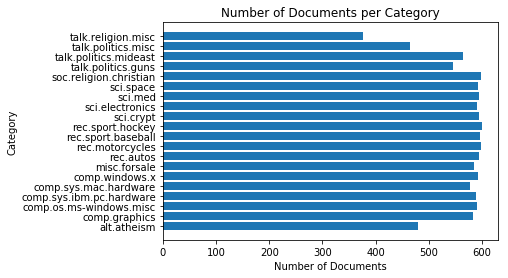

In [4]:
category = list(newsgroups_train.target_names)
count = np.zeros(20, dtype=np.int64)
for i in newsgroups_train.target:
  count[i] += 1

plt.barh(category, count)
plt.xlabel('Number of Documents')
plt.ylabel('Category')

plt.title('Number of Documents per Category')
plt.show()

## Binary Classification

---


We set the random seed to 42 to ensure consistency in the results. 

In [7]:
np.random.seed(42)
import random
random.seed(42)

We first performed binary classification on two well separated topics in the dataset: "Computed Technology" and "Recreational Activity." To train a classifier, we took all the documents in the following classes (Table 1):   

<center><b>Table 1</b>:  Two well-separated classes</center>

| Computer Technology      | Recreational Activity |
|--------------------------|-----------------------|
| `comp.graphics`            | `rec.autos`             |
| `comp.os.ms-windows.misc`  | `rec.motorcycles`       |
| `comp.sys.ibm.pc.hardware` | `rec.sport.baseball`    |
| `comp.sys.mac.hardware`    | `rec.sport.hockey`      |

In [8]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, 
                                   shuffle = True, random_state = 42)
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, 
                                  shuffle = True, random_state = 42)

### Feature Extraction

In order to perform classification (as well as other machine learning tasks) on textual data, we first need to transform the text content into numerical feature vectors that can be interpreted by a machine. The "Bag of Words" model is a common and intuitive way of representing text data. The model stores all present words in an unordered list. This means that the original syntax of the document will be lost, but instead we will gain flexibility in working with each word in the list.  
The document-term matrix is a basic representation of our group of documents (corpus) that consists of rows of words and columns of documents. Each matrix value consists of the weight for a specific term in a specific document. The calculation of the words can vary; for example, one method is to represent the number of times a word is present in the document. The advantage of having the corpus represented as a matrix is that we can perform computational calculations on it using linear algebra.  

**Document-Term Matrix**  

$\begin{pmatrix}tf(d_1, t_1) & \cdots & tf(d_1, t_m) \\ tf(d_2, t_1) & \cdots & tf(d_2, t_m) \\ \vdots & \vdots & \vdots \\ tf(d_n, t_1) & \cdots & tf(d_n, t_m) \end{pmatrix}$

$tf(d, t)$: term frequency of term $t$ in the document $d$, i.e. the number of occurrances of term $t$ in the document $d$.


The class `CountVectorizer` can help us to convert a collection of text documents to a document-term matrix, as well as perform some initial filtering on the terms to reduce the feature vector size. The `min_df` and `max_df` functions ignore terms that appear too frequently or are too rare, since such terms often carry less significant meaning in classifying a document. Stop words are words like “and”, “the”, and “him”, which are presumed to be uninformative in representing the content of a text, and which may be removed to avoid them being construed as signal for prediction. The `stop_words='english'` function uses a built-in list of english stop words.  

Especially in a large text corpus, some terms that carry very little meaningful information about the actual contents of the document will appear very frequently. If we were to feed the direct count data directly to a classifier, those very frequent terms would shadow the frequencies of rarer yet more interesting terms. The TF-IDF ("Term Frequency-Inverse Document Frequency") metric is a normalized statistic that is used to characterize how important a word is to a document in a corpus. We define the TF-IDF score to be: 
$$TF\times IDF(d,t)=tf(d,t)\times idf(t)$$
where $tf(t, d)$ represents the frequency of term $t$ in document $d$, and the inverse document frequency is defined as: 
$$idf(t)=\log(\frac{n}{df(t)})+1$$
where $n$ is the total number of documents and $df(d, t)$ is the document frequency (the number of documents that contain term $t$).



### Question 2: Feature Extraction

We preprocessed the textual data to extract features by performing the following tasks:  
- Tokenize each document by words
- Remove the `english` stopwords of the `CountVectorizer` and ignore terms that have a document frequency strictly lower than 3 (set `min_df=3`)
- Exclude terms that are numbers 
- Perform lemmatization and stemming 
- Transform data into TF-IDF representation  

The final shape of the TF-IDF matrix for the training subset is $4732 \times 16319$, and the shape of the TF-IDF matrix for the testing subset is $3150 \times 16319$. The shape of the TF-IDF matrices are reported as $d \times t$ where $d$ is the number of documents and $t$ is the number of terms.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /Users/Landi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Landi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/Landi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
UsageError: Line magic function `%%hide` not found.


In [8]:
stop_words = text.ENGLISH_STOP_WORDS
wnl = WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()

In [9]:
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. Taken from discussion slides"""
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'
      
def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]
  
def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in stop_words and not word.isdigit())


In [10]:
vectorizer = CountVectorizer(stop_words='english', min_df=3, analyzer=stem_rmv_punc)

In [11]:
print(train_dataset.data[0])
print(list(stem_rmv_punc(train_dataset.data[0])))

From: sac@asdi.saic.com (Steve A. Conroy x6172)
Subject: Re: Darrrrrrrrryl
Organization: SAIC
Lines: 33

In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) writes:
|> 
|> 
|> The media is beating the incident at Dodger Stadium on Wednesday to
|> death, but I haven't seen anything in rsb yet.
|> 
|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two
|> on and his club down by a run.  He stroked a line drive into the
|> right field corner.  The ball cleared the three-foot high fence and
|> went into the crowd.  Darryl, racing over from right center, got to
|> the spot in time to reach his glove up over the short fence, but he
|> missed the ball.  A fan sitting in the front row, wearing a mitt,
|> reached up and caught the ball.  Home run.
|> 
|> Now I've seen the replay several times and I have concluded that
|> Darryl missed the ball, and that the fan's glove was essentially
|> behind Darryl's.  Several Dodger fans with seats in the immediate
|> vicin

In [12]:
count_vec_train_matrix = vectorizer.fit_transform(train_dataset.data)
count_vec_test_matrix = vectorizer.transform(test_dataset.data)
print(count_vec_train_matrix.shape)
print(count_vec_test_matrix.shape)

(4732, 16319)
(3150, 16319)


In [13]:
#use toarray to convert sparse matrixes to ordinary matrices
train_ordinary_matrix = count_vec_train_matrix.toarray()
test_ordinary_matrix = count_vec_test_matrix.toarray()
print(train_ordinary_matrix.shape)
print(test_ordinary_matrix.shape)

(4732, 16319)
(3150, 16319)


In [14]:
#feature names are terms
vectorizer.get_feature_names()[0:100]

['0005111312na1em',
 '0010580b',
 '002251w',
 '0096b0f0',
 '00bjgood',
 '00mbstultz',
 '00pm',
 '02uv',
 '03hz',
 '03k',
 '05apr93',
 '05l',
 '06eh',
 '06paul',
 '0_',
 '0___',
 '0a',
 '0b',
 '0b14',
 '0c',
 '0d',
 '0d2',
 '0df',
 '0e',
 '0ek',
 '0f',
 '0g',
 '0g8',
 '0h',
 '0hd',
 '0i',
 '0iv',
 '0ivbudk',
 '0j',
 '0k',
 '0l',
 '0m',
 '0m75u',
 '0m8b',
 '0mk',
 '0n',
 '0o',
 '0p',
 '0q',
 '0qax',
 '0qq',
 '0r',
 '0sl',
 '0t',
 '0tbxn',
 '0tbxom',
 '0tq',
 '0tq6',
 '0u',
 '0v',
 '0va',
 '0w',
 '0x',
 '0x100',
 '0y',
 '0z',
 '1000cc',
 '100k',
 '100mph',
 '101e',
 '1024x768',
 '1024x768x16',
 '1024x768x256',
 '1024x768x65536',
 '106ps',
 '10h',
 '10k',
 '10mb',
 '10min',
 '10pm',
 '10th',
 '10w',
 '10w40',
 '115a',
 '11h',
 '11k',
 '11th',
 '1200cc',
 '120km',
 '120mb',
 '120mph',
 '125mb',
 '1280x1024',
 '128k',
 '12a',
 '12cyl',
 '12k',
 '12mb',
 '12ms',
 '12v',
 '1304s',
 '130mph',
 '132mb',
 '13h',
 '13k']

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
tfidf_train_matrix = tfidf_transformer.fit_transform(count_vec_train_matrix)
tfidf_test_matrix = tfidf_transformer.transform(count_vec_test_matrix)
print('The shape of the TF-IDF train matrix is', count_vec_train_matrix.shape)
print('The shape of the TF-IDF test matrix is', count_vec_test_matrix.shape)


The shape of the TF-IDF train matrix is (4732, 16319)
The shape of the TF-IDF test matrix is (3150, 16319)


### Question 3: Dimensionality Reduction

Since the document-term TF-IDF matrix is sparse and low-rank, we performed dimensionality reduction to improve the performance of the learning algorithm. We used two methods: Latent Semantic Indexing (LSI) and Non-negative Matrix Factorization (NMF), both of which minimize the mean-squared residual between the original data and a reconstruction from its low-dimensional approximation. We used `n_components`=50, so each document is mapped to a 50-dimensional vector. We compared the two methods.

 **LSI**

In [16]:
from sklearn.decomposition import TruncatedSVD, NMF

lsi = TruncatedSVD(n_components=50)
lsi_train_matrix = lsi.fit_transform(tfidf_train_matrix)
print(lsi_train_matrix.shape)

(4732, 50)


In [17]:
lsi_test_matrix = lsi.transform(tfidf_test_matrix)

In [18]:
estimated_lsi_train_matrix = lsi.inverse_transform(lsi_train_matrix)
lsi_error = tfidf_train_matrix-estimated_lsi_train_matrix
print(lsi_error.shape)
print(np.linalg.norm(tfidf_train_matrix-estimated_lsi_train_matrix)**2)

(4732, 16319)
4106.962861236267


**NMF**


In [19]:
nmf = NMF(n_components=50)
nmf_train_matrix = nmf.fit_transform(tfidf_train_matrix)
print(nmf_train_matrix.shape)

(4732, 50)


In [20]:
nmf_test_matrix = nmf.transform(tfidf_test_matrix)

NMF tries to approximate the data matrix $\mathbf{X} \in \mathbb{R}^{n \times m}$ (*n* documents and *m* terms) with $\mathbf{WH}$ ($\mathbf{W} \in \mathbb{R}^{m\times k}$, $\mathbf{H} \in \mathbb{R}^{k\times n}$). We have n=4732, k=50, and m=16319.  
Using k=50, we solved the NMF optimization 
\begin{array}{cc}
\min_\limits{\mathbf{W}, \mathbf{H}} & \lVert\mathbf{X} - \mathbf{W}\mathbf{H}\rVert_F^2 \ 
\end{array}

In [21]:
estimated_nmf_train_matrix = nmf.inverse_transform(nmf_train_matrix)
nmf_error = tfidf_train_matrix-estimated_nmf_train_matrix
print(nmf_error.shape)
print(np.linalg.norm(tfidf_train_matrix-estimated_nmf_train_matrix)**2)

(4732, 16319)
4143.855926086552


__Questions__: Reduce the dimensionality of the data using the methods above. Apply LSI to the TF-IDF matrix corresponding to the 8 categories with k = 50; so each document is mapped to a 50-dimensional vector. Also reduce dimensionality through NMF (k = 50) and compare with LSI:
Which one is larger, the $\lVert\mathbf{X} -\mathbf{W}\mathbf{H}\rVert_F^2$ in NMF or the$\lVert\mathbf{X} - \mathbf{U_k}\mathbf{\Sigma_k}\mathbf{V_k}^T\rVert_F^2$ in LSI?
Why is the case?

The error function $\lVert\mathbf{X} - \mathbf{W}\mathbf{H}\rVert_F^2$ in NMFis 4142.21 and the error function $\lVert\mathbf{X} - \mathbf{U_k}\mathbf{\Sigma_k}\mathbf{V_k}^T\rVert_F^2$ in LSI is 4106.96. The error function is marginally larger in NMF compared with LSI. 

The error in LSI might be because the noise (synonyms, polysems) is reduced during the dimensionality-reduction step, since the noise is assumed to be in the discarded columns and rows (Chen et al., 2013). SVD is the traditional approximation method used for LSA, wherein lower dimensional components
from the decomposition are truncated. On truncation, the linguistic noise present in the vector representation is removed, and the semantic connectedness is made visible (Peter et al., 2009).

The reason that the error in NMF is larger than the error in LSI might be because:

rank($\mathbf{U_k}\mathbf{\Sigma_k}\mathbf{V_k}^T$) = k In LSI and rank($\mathbf{W}\mathbf{H}$) $\leqslant$ k. 

When we use a lower rank to approximate the original higher dimensional $\mathbf{X}$, the error will increase. Therefore, the error of LSI is always less than or equal to the error of NMF. In other words, the error of LSI is the global minimum and the error of NMF is the minimum under the constraint that all entries in
the decomposed matrix factors have to be non-negative.

### Classification Algorithms

We used the dimension-reduced training data from LSI to train different types of classifiers, and evaluated the trained classifiers with the test data. Our data consists of 8 subclasses, each of which belong to either "Computer Technology" or "Recreational Activity." We first aggregated the documents of the subclasses into the 2 classes (refer to Table 1) so that we could perform binary classification. 

In [22]:
binary_train_labels = np.array(train_dataset.target >= 4, dtype = int)
binary_test_labels = np.array(test_dataset.target >= 4, dtype = int)
print(binary_train_labels[:5])

# print(train_dataset.target_names)
# recreational activity = 1, computer technology = 0

[1 1 1 0 0]


#### Question 4: SVM

We trained two linear support vector machines (SVM), a hard margin linear SVM and a soft margin linear SVM. We trained the hard margin SVM by using C=1000, where C is the penalty parameter of the error term (thus highly penalizing misclassification of an individual point). We trained the soft margin SVM by using C=0.0001, which is more lenient towards misclassification of a few data points as long as most of the data are well-separated.  

We evaluated and compared their classification quality of the two SVMs by looking at the ROC curves, confusion matrix, and calculating the accuracy, recall, precision, and F-1 score of both classifiers.  

In [23]:
from sklearn.svm import LinearSVC

clf_hard = LinearSVC(C = 1000).fit(lsi_train_matrix, binary_train_labels)
clf_soft = LinearSVC(C = 0.0001).fit(lsi_train_matrix, binary_train_labels)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [24]:
#Plot the ROC curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
class SparseToDenseArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X, *_):
        if hasattr(X, 'toarray'):
            return X.toarray()
        return X

    def fit(self, *_):
        return self

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
pipeline_hard = Pipeline([
    ('vect', CountVectorizer(stop_words='english', min_df=3, analyzer=stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
    ('toarr', SparseToDenseArray()),
    ('clf', SVC(kernel='linear', C=1000, random_state=42)),
])

pipeline_soft = Pipeline([
    ('vect', CountVectorizer(stop_words='english', min_df=3, analyzer=stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
    ('toarr', SparseToDenseArray()),
    ('clf', SVC(kernel='linear', C=0.0001)),
])

In [27]:
#confusion matrix

#This function prints and plots the confusion matrix
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
  #normalize can be applied by setting normalize = true
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

In [28]:
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot(pipe, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)
    # pipeline1.predict(train_dataset)

    if hasattr(pipe, 'decision_function'):
      prob_score = pipe.decision_function(test_data)
      fpr, tpr, thresholds = roc_curve(test_label, prob_score)
    else:
      prob_score = pipe.predict_proba(test_data)
      fpr, tpr, thresholds = roc_curve(test_label, prob_score[:,1])
    
    test_pred = pipe.predict(test_data)
    
    #plot roc curve
    plot_roc(fpr, tpr)
    
    #get scores
    accuracy = accuracy_score(test_label, test_pred)
    recall = recall_score(test_label, test_pred)
    precision = precision_score(test_label, test_pred)
    f1 = f1_score(test_label, test_pred)
    
    print('Accuracy = ', accuracy)
    print('Recall = ', recall)
    print('Precision = ', precision)
    print('F-1 Score = ', f1)
    
    #report the confusion matrix
    class_names = ['Computer Technology', 'Recreational Activity']
    cnf_matrix = confusion_matrix(test_label, test_pred)
    np.set_printoptions(precision=2)
    
    #plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                         title = 'Confusion Matrix (without normalization)')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = True,
                         title = 'Confusion Matrix (normalization)')
    
    plt.show()
    #return pipe
    


**Hard Margin SVM**

Accuracy =  0.9711111111111111
Recall =  0.9779874213836478
Precision =  0.9652389819987586
F-1 Score =  0.9715713839425181
Confusion matrix, without normalization
[[1504   56]
 [  35 1555]]
Normalized confusion matrix
[[0.96 0.04]
 [0.02 0.98]]


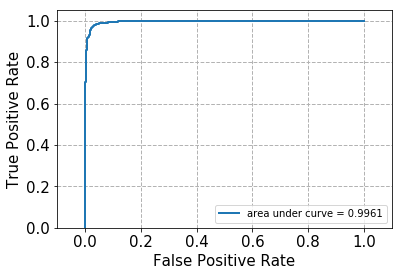

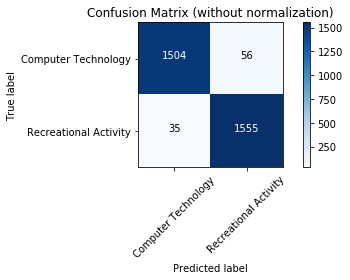

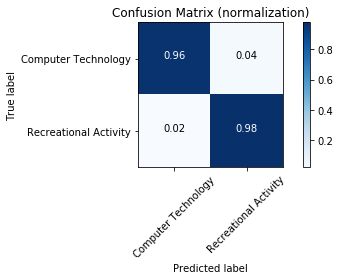

In [29]:
#plot confusion matrix, roc curve, score for hard margin
fit_predict_and_plot(pipeline_hard, train_dataset.data, binary_train_labels, test_dataset.data, binary_test_labels)

**Soft Margin SVM**

Accuracy =  0.5047619047619047
Recall =  1.0
Precision =  0.5047619047619047
F-1 Score =  0.6708860759493671
Confusion matrix, without normalization
[[   0 1560]
 [   0 1590]]
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


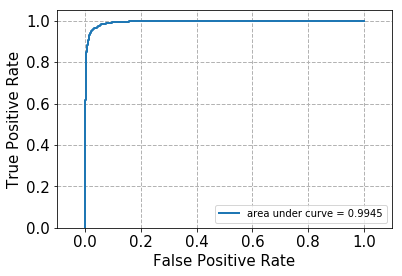

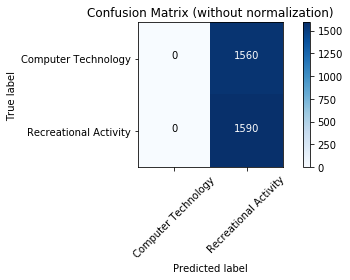

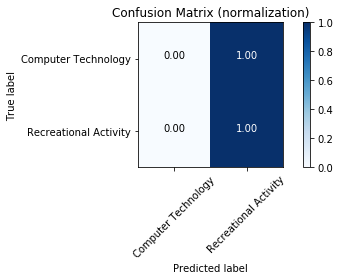

In [30]:
#plot confusion matrix, roc curve, score for soft margin
fit_predict_and_plot(pipeline_soft, train_dataset.data, binary_train_labels, test_dataset.data, binary_test_labels)

*__Questions__: Which SVM performs better? What happens for the soft margin SVM? Why is the case? Does the ROC curve of the soft margin SVM look good? Does this conflict with other metrics?*  

The area under the curve (AUC) of the ROC curve for the hard margin SVM is marginally higher compared to that for the soft margin SVM, indicating the hard margin SVM performs better in terms of separability of the data (distinguishing between the 2 classes). The accuracy, precision, and F-1 score for the hard margin SVM are higher than those for the soft margin SVM, indicating that the hard margin SVM has better overall performance.  

However, when we take a closer look at the soft margin SVM, we notice some discrepancies between the different classification metrics. For example, when we look at the confusion matrix, we notice that all of the documents were categorized into "Recreational Activity," which explains why the recall measure is 1.0. 100% of the "Recreational Activity" documents were correctly classified, while 0% of the "Computer Technology" documents were correctly classified. And although the accuracy, precision, and F-1 scores of the soft margin SVM were relatively low compared to the hard margin SVM, the AUC is very high (0.9945). However, the AUC metric does not necessarily conflict with the other metrics, as they are measuring different things. The ROC shows the tradeoff between true positive rate versus false positive rate across multiple different thresholds of classification. On the other hand, accuracy, precision, recall, and F-1 score are measures of true positives and false positives at a given threshold. 


**Cross-Validation**

We used 5-fold cross validation to choose the optimal value for the penalty parameter C in the range from $10^{-3}$ to $10^{3}$. We found that the optimal value for C is 11.498. We then used this value of C and plotted the ROC curve, reported the confusion matrix, and calculated the accuracy, recall, precision, and F-1 score of this best SVM. We observed that for all of the classification measures, this cross-validated SVM performs the best. 

In [31]:
#use cross validation to choose C

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
import numpy as np

def cross_validation(train_data, train_label):
  accuracy = []
  ngamma = 100
  gamma_test = np.logspace(-3, 3, ngamma)
  for gamma in gamma_test:
    clf = LinearSVC(C = gamma, random_state=42).fit(train_data, train_label)
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
    scores = cross_val_score(clf, train_data, train_label, cv=cv, scoring='accuracy') #something go wrong here
    accuracy.append(np.mean(scores))
  opt_gamma = gamma_test[accuracy.index(max(accuracy))]
  return opt_gamma


In [32]:
opt_gamma = cross_validation(lsi_train_matrix, binary_train_labels)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [33]:
 print(opt_gamma)

11.497569953977356


Accuracy =  0.9752380952380952
Recall =  0.9811320754716981
Precision =  0.9701492537313433
F-1 Score =  0.975609756097561
Confusion matrix, without normalization
[[1512   48]
 [  30 1560]]
Normalized confusion matrix
[[0.97 0.03]
 [0.02 0.98]]


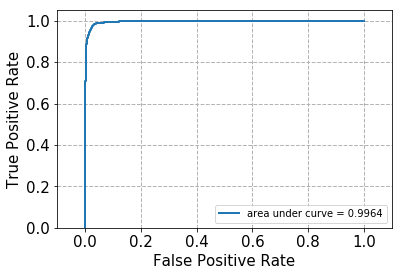

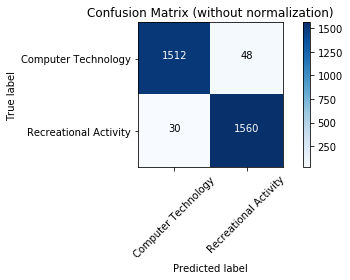

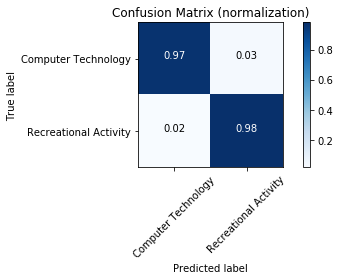

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
pipeline_opt = Pipeline([
    ('vect', CountVectorizer(stop_words='english', min_df=3, analyzer=stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
    ('toarr', SparseToDenseArray()),
    ('clf', SVC(kernel='linear', C=opt_gamma, random_state=42)),
])
fit_predict_and_plot(pipeline_opt, train_dataset.data, binary_train_labels, test_dataset.data, binary_test_labels)

#### Question 5: Logistic Regression

**Logistic Classifier Without Regularization**  
The logistic regression model is another method of performing binary classification. We first trained a logistic classifier without regularization. We did this by setting the value of C in the `sklearn.linear_model.LogisticRegression` function to a very large value. C is the inverse of regularization strength; like in support vector machines, smaller values specify stronger regularization. Thus, we set `C=100000000` to effectively ignore regularization. We also evaluated the classification quality of the logistic classifier without regularization using the same metrics as from the SVM classifiers.

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy =  0.973015873015873
Recall =  0.979874213836478
Precision =  0.9671011793916822
F-1 Score =  0.9734457981880662
Confusion matrix, without normalization
[[1507   53]
 [  32 1558]]
Normalized confusion matrix
[[0.97 0.03]
 [0.02 0.98]]


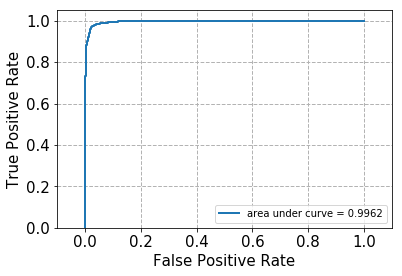

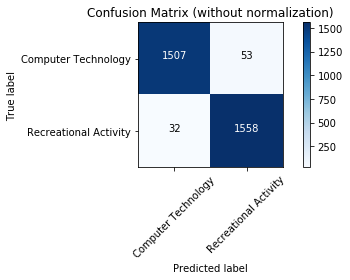

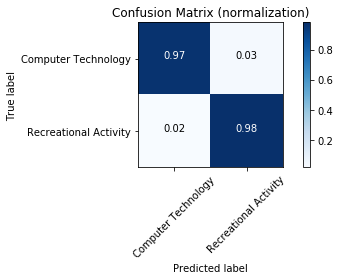

In [35]:
from sklearn.linear_model import LogisticRegression
#sklearn.linear_model.LogisticRegression

pipeline_logistics = Pipeline([
    ('vect', CountVectorizer(stop_words='english', min_df=3, analyzer=stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
    ('toarr', SparseToDenseArray()),
    ('clf', LogisticRegression(C=100000000)), #Use large gamma to effectively ignore regularization
])

fit_predict_and_plot(pipeline_logistics, train_dataset.data, binary_train_labels, test_dataset.data, binary_test_labels)

**Logistic Classifier with L1 and L2 Regularization**

We performed 5-fold cross validation to find the best regularization strength (denoted C) in the range from $10^{-3}$ to $10^3$, for logistic regression with both L1 and L2 regularization. We found the optimal C to be 17.475 for L1 regularization and 46.416 for L2 regularization. 
We compared the performance of all three logistic classifiers (no regularization, L1 and L2) using the test data. We observed that all three classifiers performed similarly on all measures (precision, recall, accuracy, and F-1 score). 

*__Questions__: How does the regularization parameter affect the test error? How are the learnt coefficients affected? Why might one be interested in each type of regularization?*  


Regularization in logistic regression adds a penalty function that penalizes against model complexity, thus addressing the problem of overfitting. An overfitted model is one that fits the training data very well but does poorly with new (test) data, thus it can result in a high test error. The regularization parameter (L1 or L2) helps control for this. The difference between the L1 and L2 is that L1 is the sum of the absolute values of the weights $w_i$, while L2 is the sum of the square of the weights. L1-norm does not have an analytical solution, while L2-norm does which results in computational efficiency in calculating it. However, the L1-norm calculation is more computationally efficient in cases where we have a sparse matrix. L1 regularization results in sparse outputs (many coefficients with zero values or very small values with few large coefficients) whereas L2 regularization results in non-sparse outputs. The effect of sparcity is that L1 regularization is good for feature selection, while L2 regularization does not have this property.

*__Questions__: Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary, then what’s the difference between their ways to find this boundary? Why does their performance differ?*  

Logistic regression and linear SVM differ in their loss function; while SVM minimizes hinge loss, logistic regression minimizes logistic loss. Logistic loss diverges faster than hinge loss, so in general logistic regression will be more sensitive to outliers. The difference between their ways to find the boundary is that SVM tries to find the widest possible separating margin, while logistic regression optimizes the log likelihood function, with probabilities modeled by the sigmoid function. We can typically expect SVM to perform marginally better than logistic regression.

https://towardsdatascience.com/support-vector-machine-vs-logistic-regression-94cc2975433f


In [36]:
def cross_validation_log(train_data, train_label, penalty):
  accuracy = []
  ngamma = 100
  gamma_test = np.logspace(-3, 3, ngamma)
  for gamma in gamma_test:
    clf = LogisticRegression(C = gamma, penalty=penalty, random_state=42).fit(train_data, train_label)
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
    scores = cross_val_score(clf, train_data, train_label, cv=cv, scoring='accuracy') #something go wrong here
    accuracy.append(np.mean(scores))
  opt_gamma = gamma_test[accuracy.index(max(accuracy))]
  return opt_gamma

In [37]:
opt_gamma_l1 = cross_validation_log(lsi_train_matrix, binary_train_labels, 'l1')
opt_gamma_l2 = cross_validation_log(lsi_train_matrix, binary_train_labels, 'l2')

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [38]:
print(opt_gamma_l1)
print(opt_gamma_l2)

17.47528400007683
46.41588833612782


In [39]:
pipeline_logistics_l1 = Pipeline([
    ('vect', CountVectorizer(stop_words='english', min_df=3, analyzer=stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
    ('toarr', SparseToDenseArray()),
    ('clf', LogisticRegression(C=opt_gamma_l1,penalty='l1')),
])

pipeline_logistics_l2 = Pipeline([
    ('vect', CountVectorizer(stop_words='english', min_df=3, analyzer=stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
    ('toarr', SparseToDenseArray()),
    ('clf', LogisticRegression(C=opt_gamma_l2,penalty='l2')),
])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy =  0.9723809523809523
Recall =  0.9792452830188679
Precision =  0.9664804469273743
F-1 Score =  0.9728209934395502
Confusion matrix, without normalization
[[1506   54]
 [  33 1557]]
Normalized confusion matrix
[[0.97 0.03]
 [0.02 0.98]]


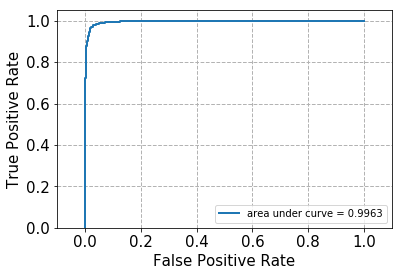

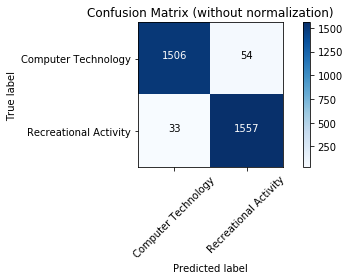

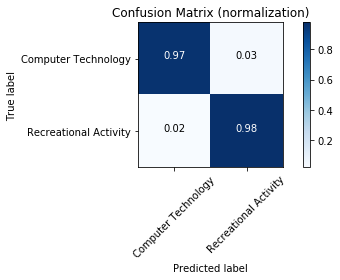

In [40]:
fit_predict_and_plot(pipeline_logistics_l1, train_dataset.data, binary_train_labels, test_dataset.data, binary_test_labels)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy =  0.9736507936507937
Recall =  0.9817610062893082
Precision =  0.9665634674922601
F-1 Score =  0.9741029641185648
Confusion matrix, without normalization
[[1506   54]
 [  29 1561]]
Normalized confusion matrix
[[0.97 0.03]
 [0.02 0.98]]


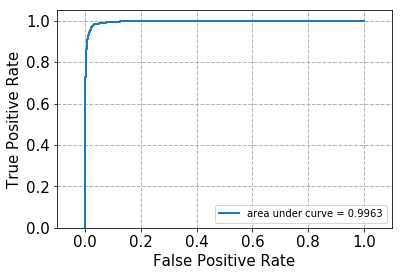

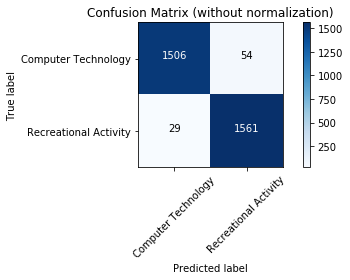

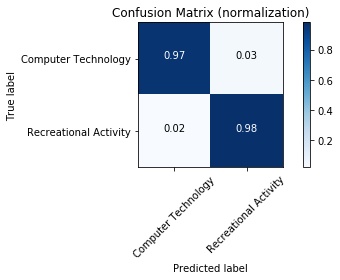

In [41]:
fit_predict_and_plot(pipeline_logistics_l2, train_dataset.data, binary_train_labels, test_dataset.data, binary_test_labels)

#### Question 6: Naïve Bayes

Naïve Bayes classifiers use the assumption that features are statistically independent of each other when conditioned by the class the data point belongs to, to simplify the calculation for the Maximum A Posteriori (MAP) estimation of the labels. We trained a Gaussian Naïve Bayes classifier, plotted the ROC curve and reported the confusion matrix. We also calculated the accuracy, recall, precision and F-1 score of this classifier. From the confusion matrix, we noticed that the proportion of documents correctly classified as "Computer Technology" was 0.84, which is slightly lower compared with the hard margin SVM and logistic classifiers. We also noticed that the accuracy and precision are slightly lower. This may be due to the assumption of conditional independence.

Accuracy =  0.9066666666666666
Recall =  0.9685534591194969
Precision =  0.8632286995515696
F-1 Score =  0.9128630705394191
Confusion matrix, without normalization
[[1316  244]
 [  50 1540]]
Normalized confusion matrix
[[0.84 0.16]
 [0.03 0.97]]


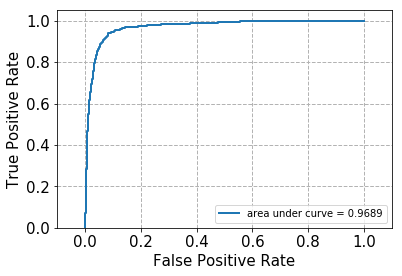

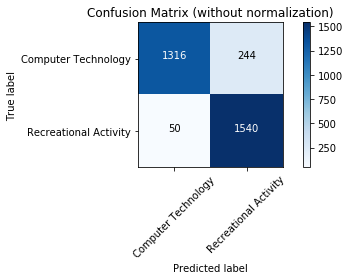

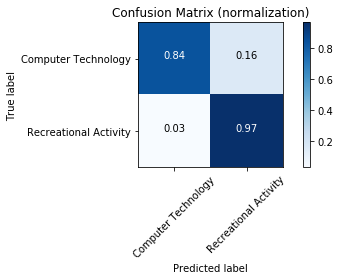

In [42]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
pipeline_GaussianNB = Pipeline([
    ('vect', CountVectorizer(stop_words='english', min_df=3, analyzer=stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
    ('toarr', SparseToDenseArray()),
    ('clf', GaussianNB()),
])

fit_predict_and_plot(pipeline_GaussianNB, train_dataset.data, binary_train_labels, test_dataset.data, binary_test_labels)

#### Question 7: Grid Search of Parameters

We performed a grid search with 5-fold cross-validation to compare the following options:  


<center><b>Table 2</b>:  Options to Compare</center>  


| Procedure                | Options                                                                               |
|:------------------------ | :------------------------------------------------------------------------------------ |
| Loading Data             | remove "headers" and "footers" vs. not                                                |
| Feature Extraction       | `min_df=3` vs `5`;  use lemmitization vs. not                                         |
| Dimensionality Reduction | LSI vs NMF                                                                            |
| Classifier               | SVM with the best $\gamma$ previously found  vs. Logistic Regression vs `GaussianNB`  |
| Other Options            | Use default                                                                           |

In [43]:
#compare nmf vs lsi, min_df=3 vs 5, gaussianNB
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.naive_bayes import GaussianNB


# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=0)


pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english', analyzer=stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=42)),
    ('clf', GaussianNB()),
],
memory=memory
)



# #N_FEATURES_OPTIONS = [10, 50]
# N_FEATURES_OPTIONS = [10]
# #C_OPTIONS = [0.1, 1, 10]
# C_OPTIONS = [0.1]


# param_grid = [
#     {
#         'vect__min_df': [3, 5],
#         'reduce_dim': [TruncatedSVD(), NMF()],
#         'reduce_dim__n_components': N_FEATURES_OPTIONS,
#         'clf': [LinearSVC()],
#         'clf__C': C_OPTIONS
#     },
#     {
#         'vect__min_df': [3, 5],
#         'reduce_dim': [TruncatedSVD(), NMF()],
#         'reduce_dim__n_components': N_FEATURES_OPTIONS,
#         'clf': [GaussianNB()]
#     },
# ]


param_grid = [
    {
        'vect__min_df': [3, 5],
#         'vect__analyzer': [stem_rmv_punc, 'word'],
        'reduce_dim': [TruncatedSVD(n_components=50), NMF(n_components=50)],
        'clf': [LinearSVC(C=23),LogisticRegression(C=30.5,penalty='l2'),GaussianNB()],
    },
]

grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')
grid.fit(train_dataset.data, binary_train_labels)
#rmtree(cachedir)

# # Search Parameters with removed headers/footers
# train_dataset_rm_head = fetch_20newsgroups(subset = 'train', categories = categories, 
#                                    shuffle = True, random_state = 42, remove=('headers', 'footers'))
# grid_rm = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')
# grid_rm.fit(train_dataset_rm_head.data, binary_train_labels)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/var/folders/9_/y5smkhjn1v75c_6sy7_m5xy40000gn/T/tmpt4j6o7ne'", use "location='/var/folders/9_/y5smkhjn1v75c_6sy7_m5xy40000gn/T/tmpt4j6o7ne'" instead.
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:230: UserWarning: Persisting input arguments took 2.90s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:230: UserWarning: Persisting input arguments took 1.68s to run.
If this happens often in your c

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=Memory(location=/var/folders/9_/y5smkhjn1v75c_6sy7_m5xy40000gn/T/tmpt4j6o7ne/joblib),
     steps=[('vect', CountVectorizer(analyzer=<function stem_rmv_punc at 0x1a1d383598>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', ...n_iter=5,
       random_state=42, tol=0.0)), ('clf', GaussianNB(priors=None, var_smoothing=1e-09))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid=[{'vect__min_df': [3, 5], 'reduce_dim': [TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=50, random_state=None, shuffle=False, solver='cd',
  tol...
          tol=0.0001, verbose=0, warm_start=False), GaussianNB(priors=None, var_smoothing=1e-09)]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       

In [44]:
import pandas as pd

pd.DataFrame(grid.cv_results_)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_reduce_dim,param_vect__min_df,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,53.535564,1.376922,12.397178,0.606390,"LinearSVC(C=23, class_weight=None, dual=True, ...","TruncatedSVD(algorithm='randomized', n_compone...",3,"{'clf': LinearSVC(C=23, class_weight=None, dua...",0.977825,0.976769,...,0.975697,0.001893,3,0.979392,0.979128,0.978600,0.979398,0.978875,0.979079,0.000308
1,54.827528,1.102771,13.205633,1.119120,"LinearSVC(C=23, class_weight=None, dual=True, ...","TruncatedSVD(algorithm='randomized', n_compone...",5,"{'clf': LinearSVC(C=23, class_weight=None, dua...",0.974657,0.977825,...,0.976543,0.002535,1,0.977807,0.977279,0.979392,0.978870,0.976763,0.978022,0.000978
2,13.289776,4.131922,13.386715,0.988273,"LinearSVC(C=23, class_weight=None, dual=True, ...","NMF(alpha=0.0, beta_loss='frobenius', init=Non...",3,"{'clf': LinearSVC(C=23, class_weight=None, dua...",0.967265,0.964097,...,0.967878,0.004641,5,0.965918,0.966446,0.970410,0.969625,0.968049,0.968090,0.001741
3,10.874119,3.369006,13.451054,1.310689,"LinearSVC(C=23, class_weight=None, dual=True, ...","NMF(alpha=0.0, beta_loss='frobenius', init=Non...",5,"{'clf': LinearSVC(C=23, class_weight=None, dua...",0.966209,0.963041,...,0.965131,0.002213,6,0.966446,0.966182,0.965654,0.963550,0.966728,0.965712,0.001138
4,0.528306,0.133817,14.977783,2.535303,"LogisticRegression(C=30.5, class_weight=None, ...","TruncatedSVD(algorithm='randomized', n_compone...",3,"{'clf': LogisticRegression(C=30.5, class_weigh...",0.974657,0.974657,...,0.975275,0.001836,4,0.978336,0.977543,0.977807,0.978077,0.978611,0.978075,0.000377
5,0.395434,0.013228,14.651172,1.717610,"LogisticRegression(C=30.5, class_weight=None, ...","TruncatedSVD(algorithm='randomized', n_compone...",5,"{'clf': LogisticRegression(C=30.5, class_weigh...",0.975713,0.976769,...,0.976120,0.000847,2,0.976486,0.975429,0.978336,0.978341,0.976763,0.977071,0.001126
6,0.418036,0.022326,12.797018,0.638060,"LogisticRegression(C=30.5, class_weight=None, ...","NMF(alpha=0.0, beta_loss='frobenius', init=Non...",3,"{'clf': LogisticRegression(C=30.5, class_weigh...",0.961985,0.965153,...,0.963018,0.001988,7,0.959577,0.962483,0.963276,0.959852,0.961447,0.961327,0.001441
7,0.436972,0.160912,13.348165,0.664207,"LogisticRegression(C=30.5, class_weight=None, ...","NMF(alpha=0.0, beta_loss='frobenius', init=Non...",5,"{'clf': LogisticRegression(C=30.5, class_weigh...",0.963041,0.967265,...,0.960693,0.004256,8,0.954293,0.965654,0.954293,0.950872,0.959599,0.956942,0.005174
8,0.417454,0.059210,14.395680,0.508048,"GaussianNB(priors=None, var_smoothing=1e-09)","TruncatedSVD(algorithm='randomized', n_compone...",3,"{'clf': GaussianNB(priors=None, var_smoothing=...",0.927138,0.923970,...,0.907861,0.028026,11,0.924967,0.918890,0.903567,0.870576,0.920518,0.907703,0.019915
9,0.341721,0.029499,13.484489,1.097828,"GaussianNB(priors=None, var_smoothing=1e-09)","TruncatedSVD(algorithm='randomized', n_compone...",5,"{'clf': GaussianNB(priors=None, var_smoothing=...",0.931362,0.884900,...,0.896450,0.028393,12,0.924174,0.889300,0.884544,0.882726,0.921310,0.900411,0.018382


In [45]:
#copy from TA discussion
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV

class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=5, n_jobs=5, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

### Question 8: Multiclass Classification

We performed Naïve Bayes classification and multiclass SVM classification on the documents belonging to the four classes: 
- `comp.sys.ibm.pc.hardware`
- `comp.sys.mac.hardware`
- `misc.forsale`
- `soc.religion.christian`   

For the multiclass SVM algorithm, we performed both one vs. one classification on all $\binom{|C|}{2}$ pairs of classes, and one vs. the rest (where we fit one classifier per class, and for each classifier, the class is fitted against all the other classes). We reported the confusion matrix and calculated the accuracy, recall, precision, and F-1 score of our classifiers. 

In [46]:
category = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
            'misc.forsale', 'soc.religion.christian']

train_data = fetch_20newsgroups(subset = 'train', categories = category, 
                                   shuffle = True, random_state = 42)
test_data = fetch_20newsgroups(subset = 'test', categories = category, 
                                  shuffle = True, random_state = 42)


In [47]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


def multiclass_classification(clf, rdim, train_data, train_label, test_data, test_label):
  pipe = Pipeline([
      ('vect', CountVectorizer(stop_words='english', min_df=3, analyzer=stem_rmv_punc)),
      ('tfidf', TfidfTransformer()),
      ('reduce_dim', rdim),
      ('toarr', SparseToDenseArray()),
      ('clf', clf),
  ])
  pipe.fit(train_data, train_label)
  
  test_pred = pipe.predict(test_data)
  #get scores
  accuracy = accuracy_score(test_label, test_pred)
  recall = recall_score(test_label, test_pred, average='micro')
  precision = precision_score(test_label, test_pred, average='micro')
  f1 = f1_score(test_label, test_pred , average='micro')
    
  print('Accuracy = ', accuracy)
  print('Recall = ', recall)
  print('Precision = ', precision)
  print('F-1 Score = ', f1)
    
  #report the confusion matrix
  class_names = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
                 'misc.forsale', 'soc.religion.christian']
  cnf_matrix = confusion_matrix(test_label, test_pred)
  np.set_printoptions(precision=2)
    
  #plot non-normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=class_names,
                        title = 'Confusion Matrix (without normalization)')
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = True,
                        title = 'Confusion Matrix (normalization)')
    
  plt.show()
  #return pipe
    



Accuracy =  0.7789137380191693
Recall =  0.7789137380191693
Precision =  0.7789137380191693
F-1 Score =  0.7789137380191693
Confusion matrix, without normalization
[[303  32  53   4]
 [ 93 212  66  14]
 [ 58   7 314  11]
 [  0   0   8 390]]
Normalized confusion matrix
[[0.77 0.08 0.14 0.01]
 [0.24 0.55 0.17 0.04]
 [0.15 0.02 0.81 0.03]
 [0.   0.   0.02 0.98]]


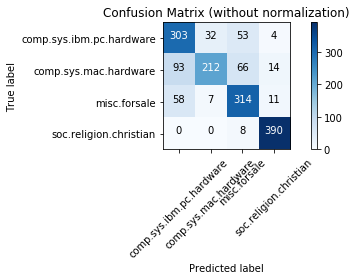

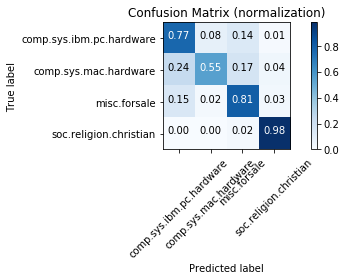

In [48]:
#Naïve Bayes classification
#Use NMF bc Naives Bayes requires positive X
multiclass_classification(MultinomialNB(), NMF(n_components=50), train_data.data, 
                          train_data.target, test_data.data, test_data.target)

Accuracy =  0.8811501597444089
Recall =  0.8811501597444089
Precision =  0.8811501597444089
F-1 Score =  0.8811501597444089
Confusion matrix, without normalization
[[322  44  25   1]
 [ 38 326  21   0]
 [ 27  19 341   3]
 [  4   1   3 390]]
Normalized confusion matrix
[[0.82 0.11 0.06 0.  ]
 [0.1  0.85 0.05 0.  ]
 [0.07 0.05 0.87 0.01]
 [0.01 0.   0.01 0.98]]


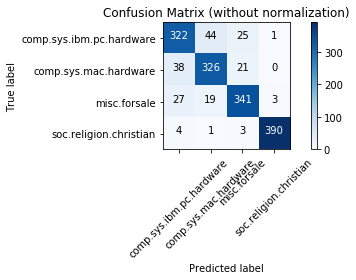

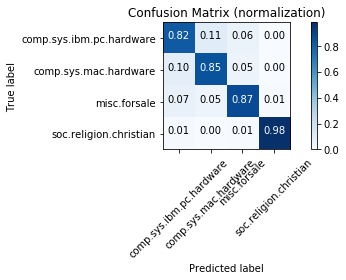

In [49]:
#oneVSone svm

from sklearn.multiclass import OneVsOneClassifier

multiclass_classification(OneVsOneClassifier(LinearSVC(C=opt_gamma, random_state=42)), 
                          TruncatedSVD(n_components=50, random_state=42), 
                          train_data.data, train_data.target, test_data.data, test_data.target)

Accuracy =  0.8817891373801917
Recall =  0.8817891373801917
Precision =  0.8817891373801917
F-1 Score =  0.8817891373801917
Confusion matrix, without normalization
[[315  54  22   1]
 [ 34 327  23   1]
 [ 24  18 346   2]
 [  4   1   1 392]]
Normalized confusion matrix
[[0.8  0.14 0.06 0.  ]
 [0.09 0.85 0.06 0.  ]
 [0.06 0.05 0.89 0.01]
 [0.01 0.   0.   0.98]]


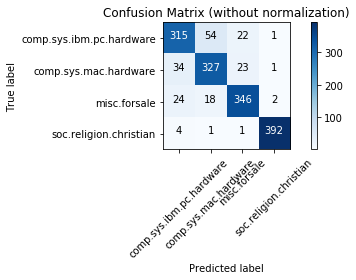

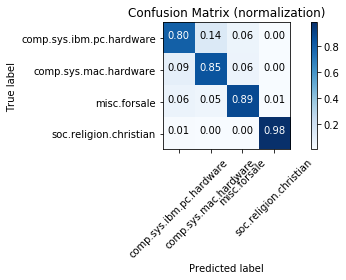

In [50]:
#OneVsRest svm
from sklearn.multiclass import OneVsRestClassifier
multiclass_classification(OneVsRestClassifier(LinearSVC(C=opt_gamma, random_state=42)), 
                          TruncatedSVD(n_components=50, random_state=42), 
                          train_data.data, train_data.target, test_data.data, test_data.target)